## Setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2024-11-14 12:20:58.697225: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1


In [150]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

import os
import kagglehub

Path to the content and style images, download the pre-trained TensorFlow Lite models.

In [151]:
content_path = '/Users/Anelya/Desktop/courses/dl/project/original.jpeg'
style_1_path = '/Users/Anelya/Desktop/courses/dl/project/style5.png'
style_2_path = '/Users/Anelya/Desktop/courses/dl/project/style1.jpeg'

style_predict_path = kagglehub.model_download("google/arbitrary-image-stylization-v1/tfLite/256-int8-prediction")
style_transform_path = kagglehub.model_download("google/arbitrary-image-stylization-v1/tfLite/256-int8-transfer")

## Pre-process the inputs

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.
* The content image must be (1, 384, 384, 3). We central crop the image and resize it.

In [152]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    
    return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes 256px.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image

In [153]:
# Load the input images.
content_image = load_img(content_path)
style_1_image = load_img(style_1_path)
style_2_image = load_img(style_2_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_1_image = preprocess_image(style_1_image, 256)
preprocessed_style_2_image = preprocess_image(style_2_image, 256)

print('Style 1 Image Shape:', preprocessed_style_1_image.shape)
print('Style 2 Image Shape:', preprocessed_style_2_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style 1 Image Shape: (1, 256, 256, 3)
Style 2 Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


## Visualize the inputs

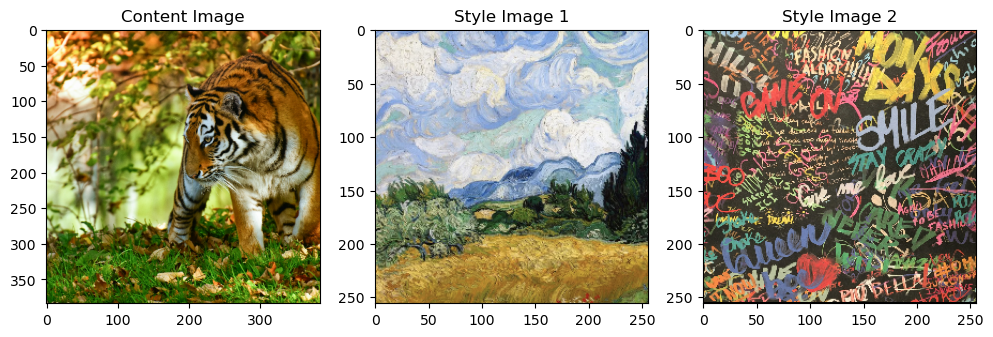

In [157]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    
    if title:
        plt.title(title)

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(preprocessed_style_1_image, 'Style Image 1')

plt.subplot(1, 3, 3)
imshow(preprocessed_style_2_image, 'Style Image 2')

## Run style transfer with TensorFlow Lite

In [135]:
style_predict_path

'/Users/Anelya/.cache/kagglehub/models/google/arbitrary-image-stylization-v1/tfLite/256-int8-prediction/1'

In [136]:
style_transform_path

'/Users/Anelya/.cache/kagglehub/models/google/arbitrary-image-stylization-v1/tfLite/256-int8-transfer/1'

In [137]:
import os 

filename_predict = '1.tflite'
filename_transform = '1.tflite'

full_path_predict = os.path.join(style_predict_path, filename_predict)
full_path_transform = os.path.join(style_transform_path, filename_transform)

In [138]:
full_path_transform

'/Users/Anelya/.cache/kagglehub/models/google/arbitrary-image-stylization-v1/tfLite/256-int8-transfer/1/1.tflite'

In [139]:
full_path_predict

'/Users/Anelya/.cache/kagglehub/models/google/arbitrary-image-stylization-v1/tfLite/256-int8-prediction/1/1.tflite'

### Style prediction

In [140]:
import os 

# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=full_path_predict)

    # Set model input.
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

    # Calculate style bottleneck.
    interpreter.invoke()
    style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

    return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_1_bottleneck = run_style_predict(preprocessed_style_1_image)
style_2_bottleneck = run_style_predict(preprocessed_style_2_image)
print('Style 1 Bottleneck Shape:', style_1_bottleneck.shape)
print('Style 2 Bottleneck Shape:', style_2_bottleneck.shape)

Style 1 Bottleneck Shape: (1, 1, 1, 100)
Style 2 Bottleneck Shape: (1, 1, 1, 100)


### Style transform

In [141]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=full_path_transform)

    # Set model input.
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()

    # Set model inputs.
    interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
    interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
    interpreter.invoke()

    # Transform content image.
    stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

    return stylized_image

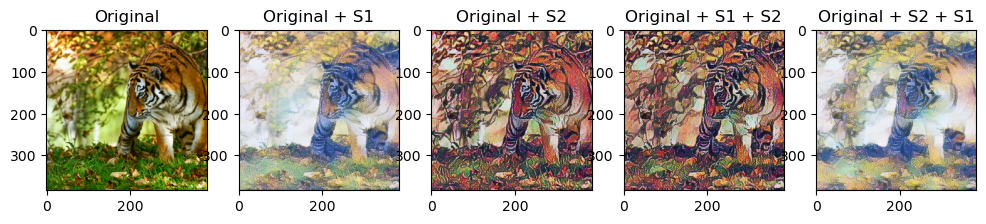

In [142]:
# Stylize the content image using the style bottleneck.
stylized_image_1 = run_style_transform(style_1_bottleneck, preprocessed_content_image)

stylized_image_2 = run_style_transform(style_2_bottleneck, preprocessed_content_image)

stylized_image_1_2 = run_style_transform(style_2_bottleneck, stylized_image_1)

stylized_image_2_1 = run_style_transform(style_1_bottleneck, stylized_image_2)

plt.subplot(1, 5, 1)
imshow(preprocessed_content_image, 'Original')

plt.subplot(1, 5, 2)
imshow(stylized_image_1, 'Original + S1')

plt.subplot(1, 5, 3)
imshow(stylized_image_2, 'Original + S2')

plt.subplot(1, 5, 4)
imshow(stylized_image_1_2, 'Original + S1 + S2')

plt.subplot(1, 5, 5)
imshow(stylized_image_2_1, 'Original + S2 + S1')

### Mean of style bottlenecks 

In [143]:
style_bottleneck = style_1_bottleneck.copy()
for i in range(100):
    if i % 2 == 1:
        style_bottleneck[0, 0, 0, i] = style_2_bottleneck[0, 0, 0, i]

In [145]:
# Stylize the content image using the style bottleneck.
stylized_image_mean = run_style_transform(style_bottleneck, preprocessed_content_image)

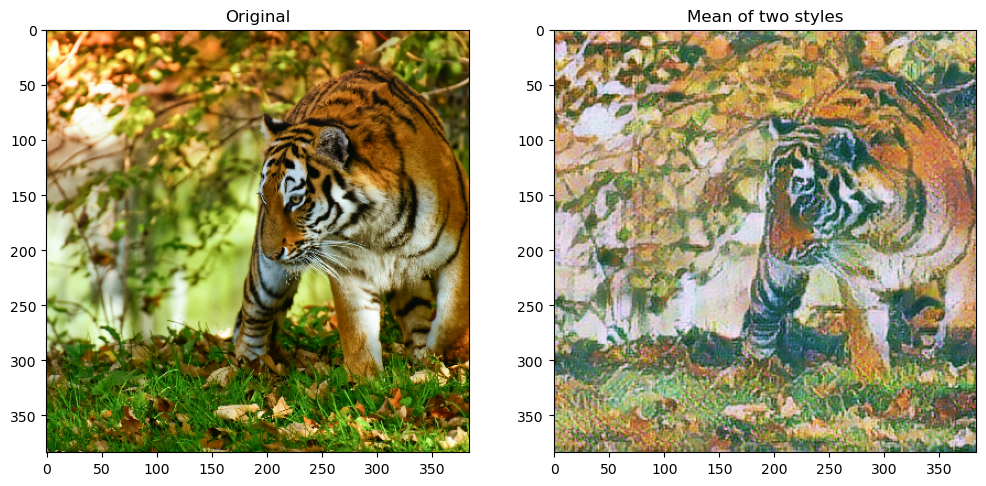

In [146]:
plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Original')

plt.subplot(1, 2, 2)
imshow(stylized_image_mean, 'Mean of two styles')

### Style blending

We can blend the style of content image into the stylized output, which in turn making the output look more like the content image.

In [147]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

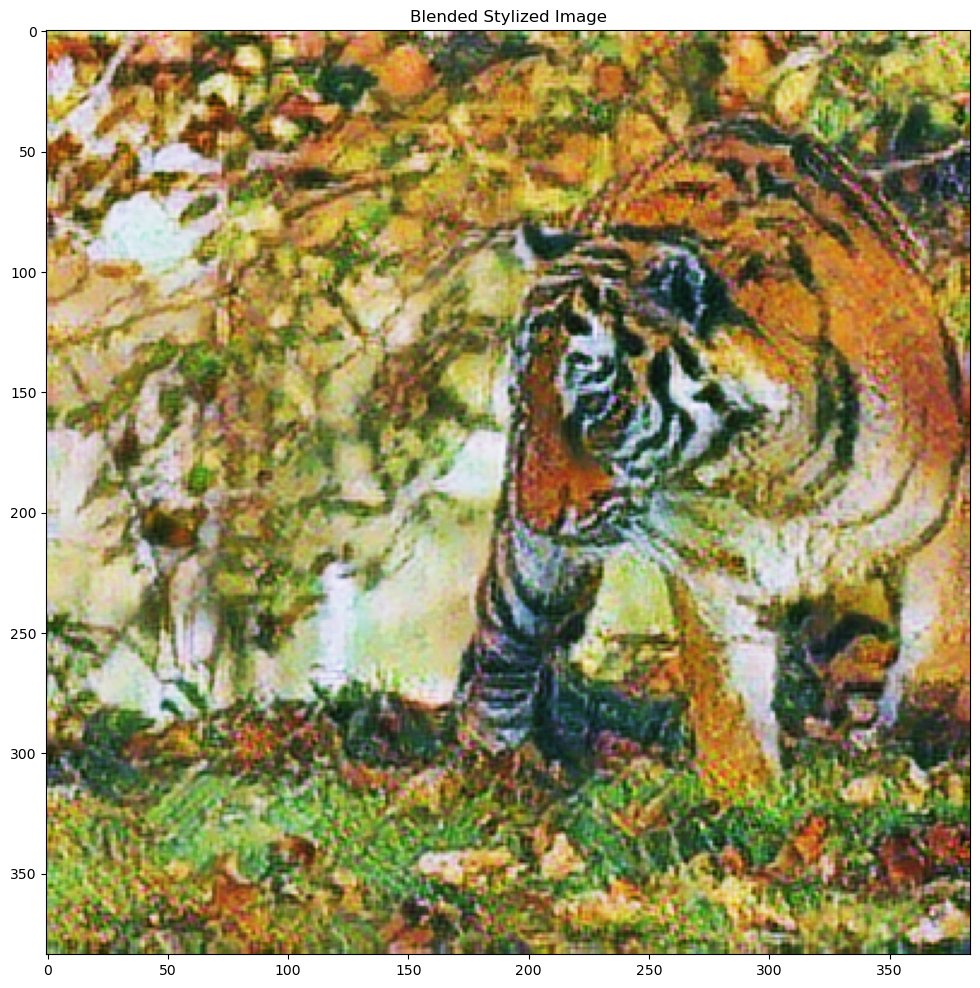

In [160]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')